<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/Classification/multiclass/cnn_multiclass_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Source:

* https://www.kaggle.com/cfpb/us-consumer-finance-complaints


In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import download as nltk_downloader
nltk_downloader("stopwords")
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, Dropout, GlobalMaxPool1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
seed = 2021
# maximum number of words in our vocabulary
input_dim = 50000
# maximum number of words within each complaint document 
max_len = 250
output_dim = 100
batch_size = 128
epochs = 100
earlystopping_patience = 3

np.random.seed(seed)

In [3]:
# Read the input dataset 
df = pd.read_csv("/content/drive/MyDrive/consumer_complaints.csv", 
                usecols=("product", "consumer_complaint_narrative"),
                dtype={"consumer_complaint_narrative": object})

# Only interested in data with consumer complaints
df = df[df["consumer_complaint_narrative"].notnull()]
df = df[df["product"].notnull()]
df.reset_index(drop=True, inplace=True)
df = df.dropna()

num_classes = len(np.unique(df["product"]))

print(df["product"].value_counts())

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64


In [4]:
def clean_text(text):
  text = text.lower()
  pattern = re.compile(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]")
  text = re.sub(pattern,"",text)
  # remove x from the text
  text = text.replace("x", "")
  text = text.split()
  texts = [word for word in text if word.isalpha()]
  stop_words = set(stopwords.words("english"))
  cleaned_text = [word for word in texts if word not in stop_words]
  cleaned_text = " ".join(cleaned_text)
  return cleaned_text


df["cleaned_consumer_complaint_narrative"] = df["consumer_complaint_narrative"].apply(clean_text)
df.head()

,product,consumer_complaint_narrative,cleaned_consumer_complaint_narrative
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,claimed owe years despite proof payment sent c...
1,Consumer Loan,Due to inconsistencies in the amount owed that...,due inconsistencies amount owed told bank amou...
2,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,wages earned job decreased almost half knew tr...
3,Mortgage,I have an open and current mortgage with Chase...,open current mortgage chase bank chase reporti...
4,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,submitted time submitted complaint dealt rushm...


In [5]:
X = df["cleaned_consumer_complaint_narrative"].values
y = df["product"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print("Volume of Training dataset: {}".format(len(X_train)))
print("Volume of Testing dataset: {}".format(len(X_test)))

Volume of Training dataset: 53444
Volume of Testing dataset: 13362


In [6]:
class ProcessX:
  def __init__(self, x, input_dim):
    self.tokenizer = Tokenizer(num_words=input_dim, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
    self.tokenizer.fit_on_texts(x)
  
  def process(self, x, padding="post", max_len=100):
    x_processed = self.tokenizer.texts_to_sequences(x)
    x_processed = pad_sequences(x_processed, padding="post", maxlen=max_len)
    return x_processed

In [7]:
# Label Encoding categorical data for the classification category

def process_y(y):
  labels_encoder = LabelEncoder()
  y_processed = labels_encoder.fit_transform(y)
  labels = np.unique(y_processed)
  label_names = labels_encoder.inverse_transform(labels)
  y_processed = to_categorical(y_processed, num_classes=num_classes)
  return y_processed, labels, label_names

In [8]:
def plot_perf(history):
  # Create a plot of accuracy and loss over time
  history_dict = history.history
  history_dict.keys()

  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  loss = history_dict["loss"]
  val_loss = history_dict["val_loss"]

  epochs = range(1, len(acc) + 1)

  # Use plot styling from seaborn.
  sns.set(style="darkgrid")
  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12, 6)

  # Training and validation loss
  plt.plot(epochs, loss, "r", label="Training loss")
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  # Training and validation accuracy
  plt.plot(epochs, acc, "r", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")
  plt.show()

KFold: 1 starts.
Epoch 1/100
376/376 [==============================] - 55s 59ms/step - loss: 1.4902 - accuracy: 0.4831 - val_loss: 0.6433 - val_accuracy: 0.8009
Epoch 2/100
376/376 [==============================] - 22s 58ms/step - loss: 0.5532 - accuracy: 0.8310 - val_loss: 0.5651 - val_accuracy: 0.8273
Epoch 3/100
376/376 [==============================] - 22s 58ms/step - loss: 0.3467 - accuracy: 0.8978 - val_loss: 0.5664 - val_accuracy: 0.8402
Epoch 4/100
376/376 [==============================] - 22s 57ms/step - loss: 0.2109 - accuracy: 0.9406 - val_loss: 0.6088 - val_accuracy: 0.8331
Epoch 5/100
418/418 [==============================] - 2s 3ms/step - loss: 0.5654 - accuracy: 0.8253


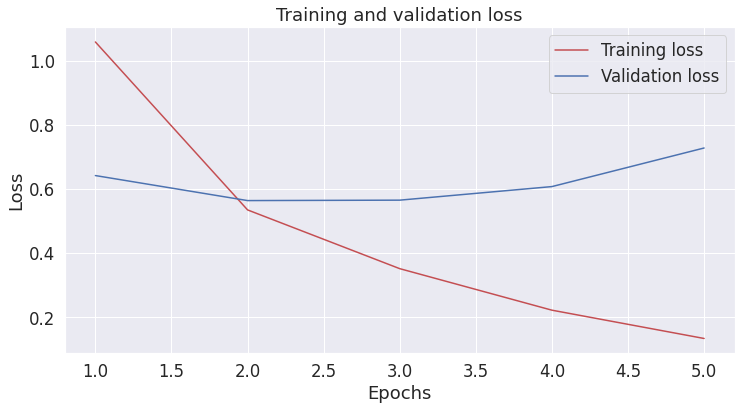

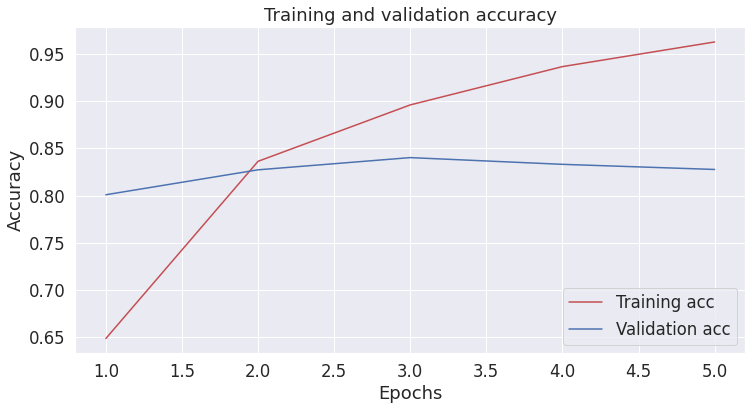

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

Bank account or service      0.702     0.801     0.749      1122
          Consumer Loan      0.548     0.614     0.580       682
            Credit card      0.789     0.822     0.805      1633
       Credit reporting      0.830     0.882     0.855      2527
        Debt collection      0.881     0.816     0.847      3524
        Money transfers      0.000     0.000     0.000       147
               Mortgage      0.917     0.946     0.931      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.000     0.000     0.000       149
           Prepaid card      0.832     0.639     0.723       194
           Student loan      0.714     0.833     0.769       377

               accuracy                          0.825     13362
              macro avg      0.565     0.578     0.569     13362
           weighted avg      0.810     0.825     0.816     13362


KFold: 2 starts.
Epoc

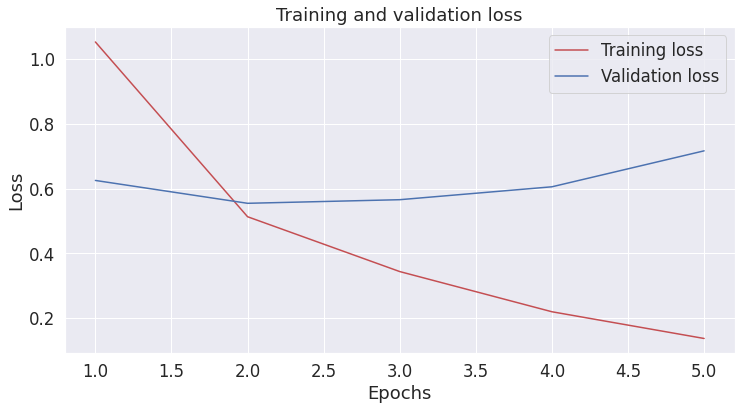

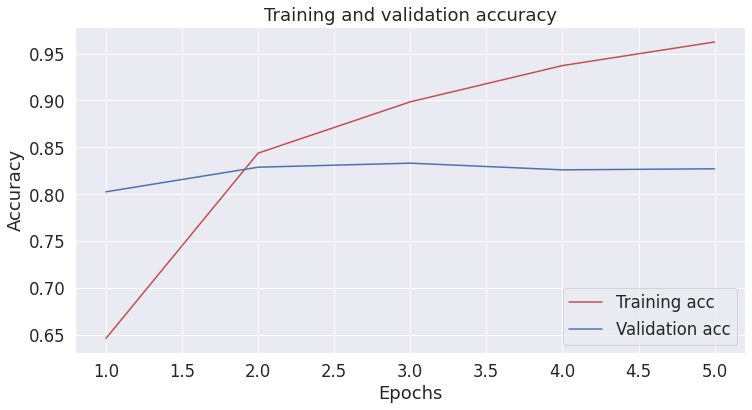

                         precision    recall  f1-score   support

Bank account or service      0.713     0.779     0.744      1122
          Consumer Loan      0.659     0.532     0.589       682
            Credit card      0.741     0.854     0.794      1633
       Credit reporting      0.881     0.837     0.858      2527
        Debt collection      0.829     0.876     0.852      3524
        Money transfers      0.889     0.163     0.276       147
               Mortgage      0.932     0.944     0.938      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.000     0.000     0.000       149
           Prepaid card      0.725     0.665     0.694       194
           Student loan      0.841     0.788     0.814       377

               accuracy                          0.831     13362
              macro avg      0.655     0.585     0.596     13362
           weighted avg      0.822     0.831     0.822     13362


KFold: 3 starts.
Epoc

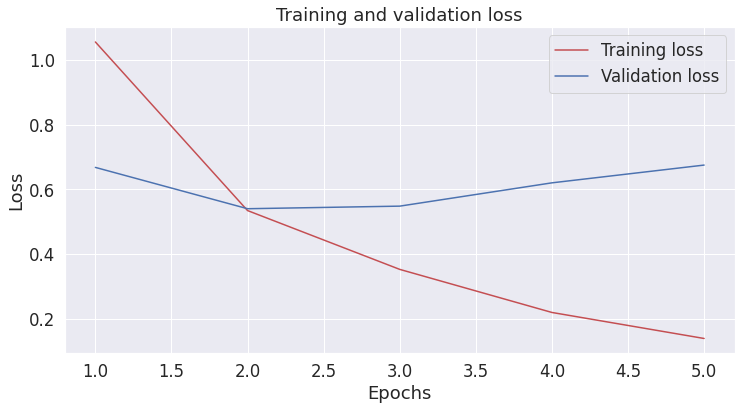

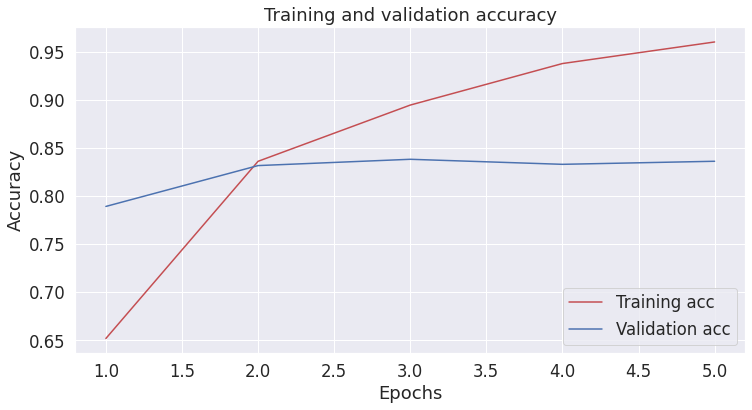

                         precision    recall  f1-score   support

Bank account or service      0.722     0.791     0.755      1122
          Consumer Loan      0.637     0.566     0.599       682
            Credit card      0.809     0.809     0.809      1633
       Credit reporting      0.845     0.877     0.861      2527
        Debt collection      0.828     0.873     0.850      3524
        Money transfers      0.808     0.286     0.422       147
               Mortgage      0.932     0.938     0.935      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.500     0.027     0.051       149
           Prepaid card      0.759     0.665     0.709       194
           Student loan      0.895     0.767     0.826       377

               accuracy                          0.835     13362
              macro avg      0.703     0.600     0.620     13362
           weighted avg      0.829     0.835     0.828     13362


KFold: 4 starts.
Epoc

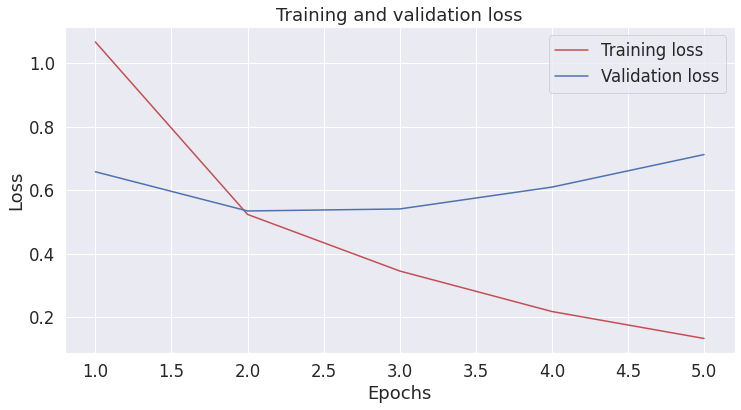

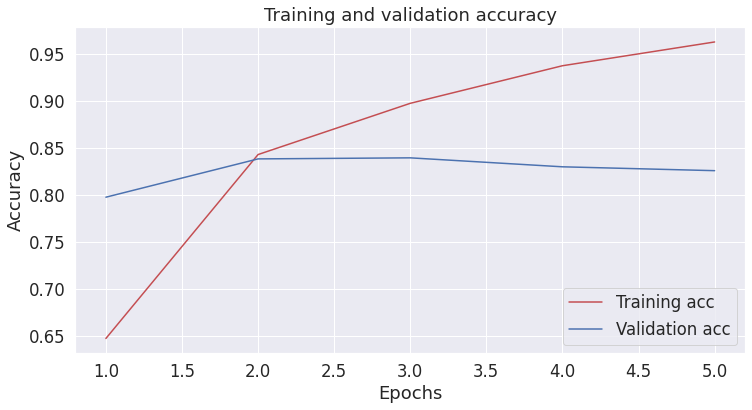

                         precision    recall  f1-score   support

Bank account or service      0.766     0.766     0.766      1122
          Consumer Loan      0.522     0.673     0.588       682
            Credit card      0.803     0.806     0.805      1633
       Credit reporting      0.848     0.869     0.858      2527
        Debt collection      0.863     0.845     0.854      3524
        Money transfers      0.729     0.347     0.470       147
               Mortgage      0.923     0.944     0.933      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.000     0.000     0.000       149
           Prepaid card      0.664     0.742     0.701       194
           Student loan      0.899     0.804     0.849       377

               accuracy                          0.833     13362
              macro avg      0.638     0.618     0.620     13362
           weighted avg      0.826     0.833     0.828     13362


KFold: 5 starts.
Epoc

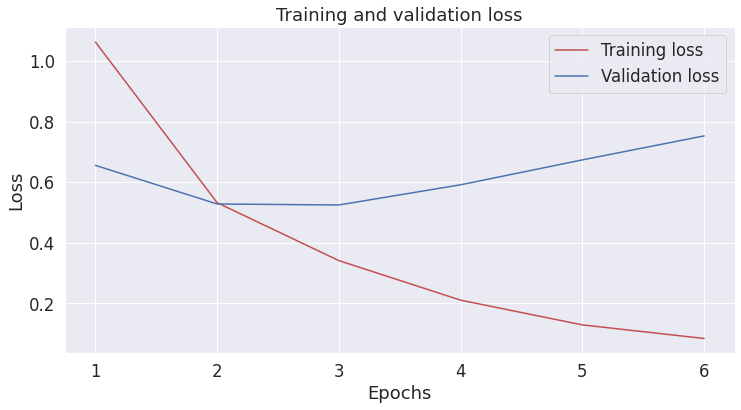

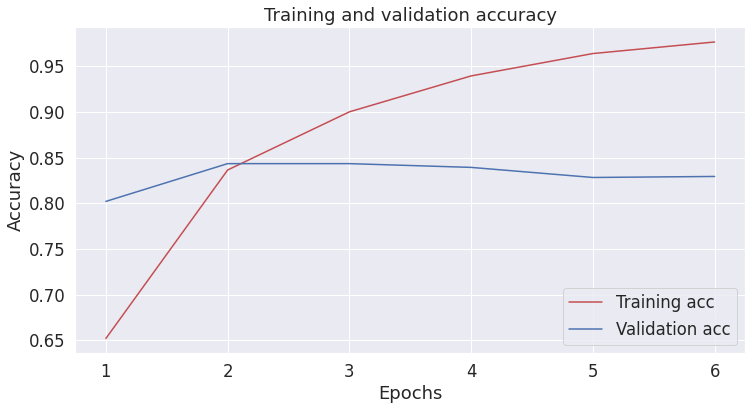

                         precision    recall  f1-score   support

Bank account or service      0.732     0.815     0.771      1122
          Consumer Loan      0.599     0.641     0.619       682
            Credit card      0.823     0.789     0.806      1633
       Credit reporting      0.868     0.852     0.860      2527
        Debt collection      0.830     0.870     0.850      3524
        Money transfers      0.632     0.537     0.581       147
               Mortgage      0.935     0.923     0.929      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.478     0.148     0.226       149
           Prepaid card      0.810     0.680     0.739       194
           Student loan      0.843     0.809     0.825       377

               accuracy                          0.835     13362
              macro avg      0.686     0.642     0.655     13362
           weighted avg      0.833     0.835     0.832     13362


KFold: 6 starts.
Epoc

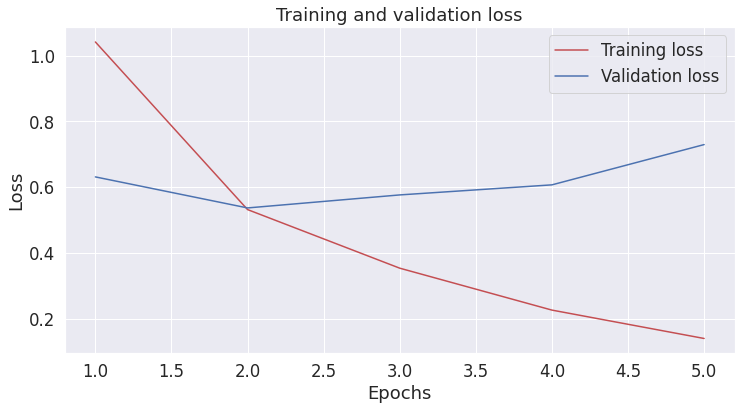

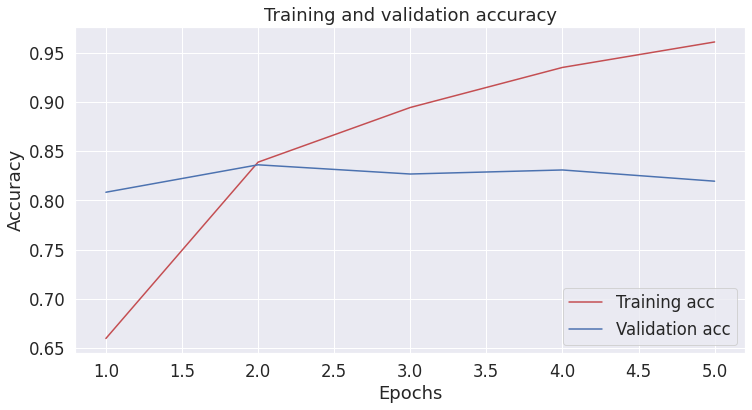

                         precision    recall  f1-score   support

Bank account or service      0.714     0.766     0.739      1122
          Consumer Loan      0.648     0.513     0.573       682
            Credit card      0.766     0.852     0.807      1633
       Credit reporting      0.833     0.876     0.854      2527
        Debt collection      0.856     0.846     0.851      3524
        Money transfers      0.750     0.020     0.040       147
               Mortgage      0.925     0.946     0.935      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.333     0.020     0.038       149
           Prepaid card      0.794     0.696     0.742       194
           Student loan      0.732     0.817     0.772       377

               accuracy                          0.828     13362
              macro avg      0.668     0.578     0.577     13362
           weighted avg      0.821     0.828     0.818     13362


KFold: 7 starts.
Epoc

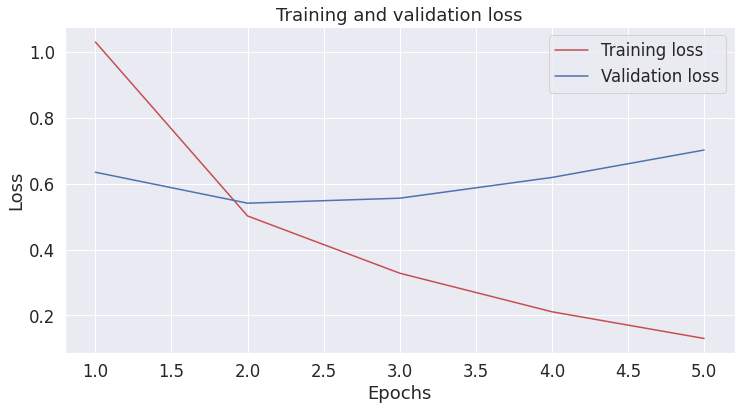

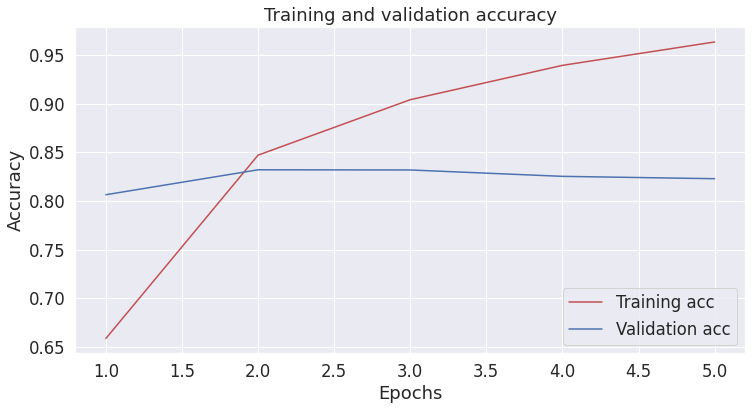

                         precision    recall  f1-score   support

Bank account or service      0.742     0.774     0.757      1122
          Consumer Loan      0.633     0.619     0.626       682
            Credit card      0.824     0.786     0.804      1633
       Credit reporting      0.837     0.884     0.860      2527
        Debt collection      0.854     0.866     0.860      3524
        Money transfers      0.772     0.299     0.431       147
               Mortgage      0.932     0.948     0.940      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.645     0.134     0.222       149
           Prepaid card      0.628     0.747     0.682       194
           Student loan      0.796     0.775     0.785       377

               accuracy                          0.838     13362
              macro avg      0.697     0.621     0.633     13362
           weighted avg      0.834     0.838     0.833     13362


KFold: 8 starts.
Epoc

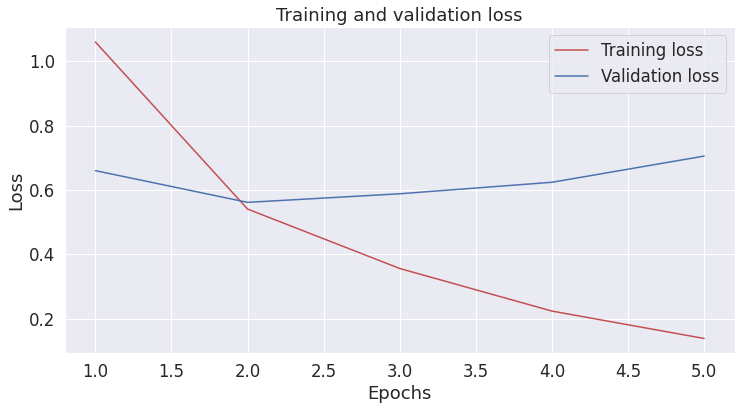

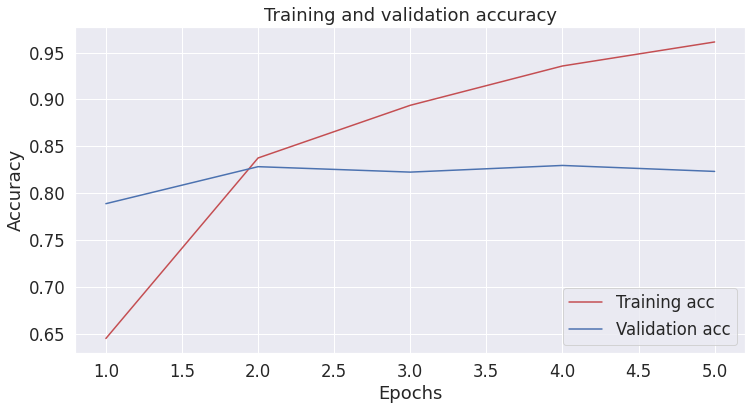

                         precision    recall  f1-score   support

Bank account or service      0.686     0.799     0.738      1122
          Consumer Loan      0.523     0.610     0.563       682
            Credit card      0.808     0.777     0.792      1633
       Credit reporting      0.853     0.865     0.859      2527
        Debt collection      0.832     0.881     0.856      3524
        Money transfers      0.000     0.000     0.000       147
               Mortgage      0.942     0.921     0.931      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.000     0.000     0.000       149
           Prepaid card      0.743     0.552     0.633       194
           Student loan      0.859     0.759     0.806       377

               accuracy                          0.824     13362
              macro avg      0.568     0.560     0.562     13362
           weighted avg      0.809     0.824     0.816     13362


KFold: 9 starts.
Epoc

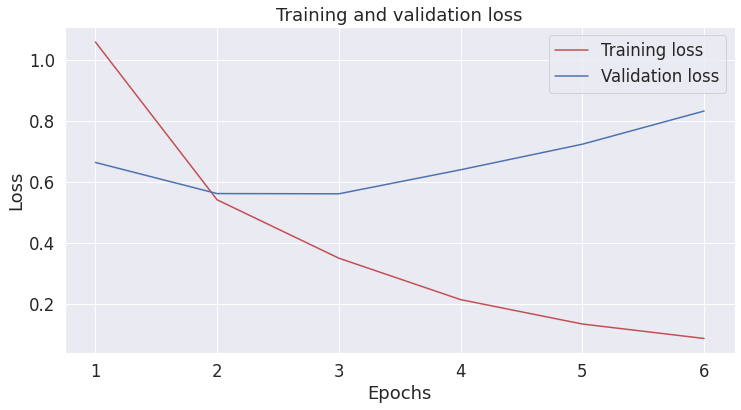

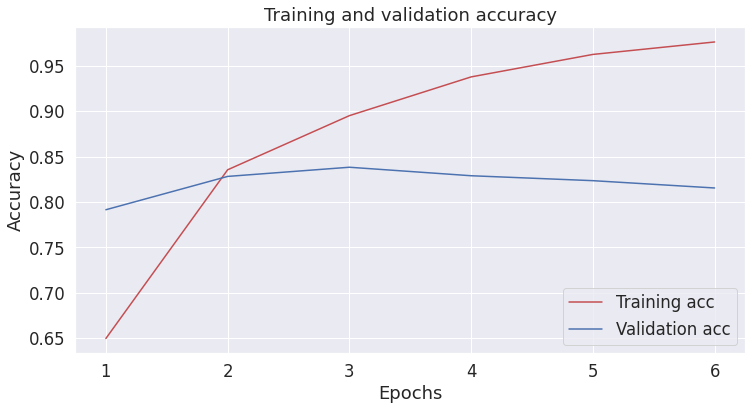

                         precision    recall  f1-score   support

Bank account or service      0.823     0.671     0.739      1122
          Consumer Loan      0.596     0.639     0.617       682
            Credit card      0.767     0.851     0.807      1633
       Credit reporting      0.860     0.871     0.865      2527
        Debt collection      0.852     0.850     0.851      3524
        Money transfers      0.627     0.503     0.558       147
               Mortgage      0.913     0.947     0.930      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.604     0.215     0.317       149
           Prepaid card      0.764     0.686     0.723       194
           Student loan      0.824     0.846     0.835       377

               accuracy                          0.835     13362
              macro avg      0.694     0.644     0.658     13362
           weighted avg      0.833     0.835     0.832     13362


KFold: 10 starts.
Epo

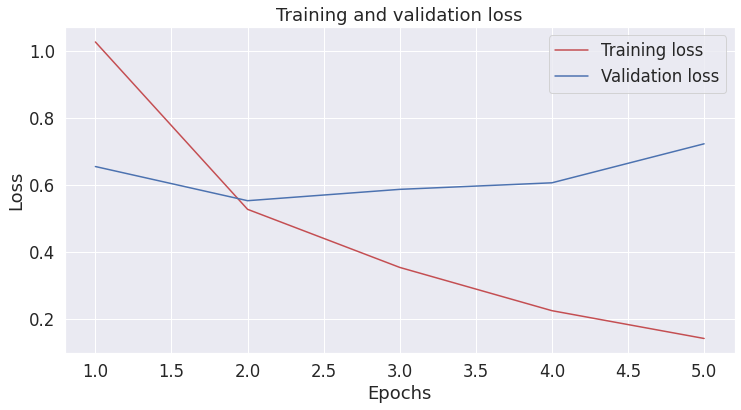

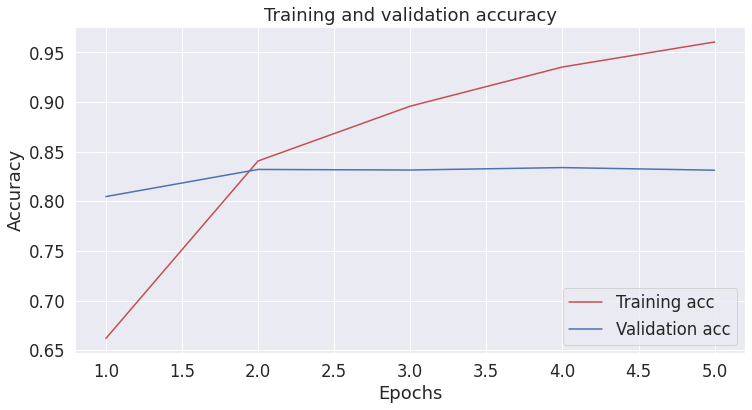

                         precision    recall  f1-score   support

Bank account or service      0.791     0.748     0.769      1122
          Consumer Loan      0.571     0.625     0.597       682
            Credit card      0.756     0.850     0.800      1633
       Credit reporting      0.869     0.842     0.855      2527
        Debt collection      0.842     0.870     0.856      3524
        Money transfers      0.673     0.252     0.366       147
               Mortgage      0.926     0.941     0.933      2987
Other financial service      0.000     0.000     0.000        20
            Payday loan      0.333     0.013     0.026       149
           Prepaid card      0.729     0.722     0.725       194
           Student loan      0.864     0.790     0.825       377

               accuracy                          0.833     13362
              macro avg      0.669     0.605     0.614     13362
           weighted avg      0.828     0.833     0.827     13362


Average accuracy: 0.8

In [9]:
# Create and train the model

earlystop_callback = EarlyStopping(
  monitor="val_loss",
  min_delta=0.0001,
  patience=earlystopping_patience,
  restore_best_weights=True)

process_X = ProcessX(x=X, input_dim=input_dim)
X_test_processed = process_X.process(x=X_test, padding="post", max_len=max_len)
y_test_processed, _, _ = process_y(y_test)

kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
model = None
cv_acc = []
cv_loss = []
cv_f1 = []

for n, (train, valid) in enumerate(kfold.split(X_train, y_train)):
  print("KFold: {} starts.".format(n + 1))
  del model
  tf.keras.backend.clear_session()

  X_train_split = X_train[train]
  y_train_split = y_train[train]
  X_valid_split = X_train[valid]
  y_valid_split = y_train[valid]

  X_train_split_processed = process_X.process(x=X_train_split, padding="post", max_len=max_len)
  y_train_split_processed, labels, label_names = process_y(y_train_split)
  X_valid_split_processed = process_X.process(x=X_valid_split, padding="post", max_len=max_len)
  y_valid_split_processed, _, _ = process_y(y_valid_split)

  model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_len),
    Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
    MaxPool1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
    GlobalMaxPool1D(),
    Flatten(),
    # Hidden layers
    Dense(units=250, activation="relu"),
    Dropout(rate=0.2, noise_shape=None, seed=None),
    Dense(units=250, activation="relu"),
    Dropout(rate=0.2, noise_shape=None, seed=None),
    # Output layer
    Dense(units=num_classes, activation="sigmoid")
  ])

  model.compile(
      loss="categorical_crossentropy",
      optimizer="adam",
      metrics=["accuracy"]
  )

  # model.summary()

  history = model.fit(
      x=X_train_split_processed,
      y=y_train_split_processed,
      validation_data=(X_valid_split_processed, y_valid_split_processed),
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      callbacks=[earlystop_callback]
  )

  loss, acc = model.evaluate(x=X_test_processed, y=y_test_processed, verbose=1)
  cv_acc.append(acc)
  cv_loss.append(loss)

  plot_perf(history)

  # # np.argmax(model.predict(x), axis=-1), if your model does multi-class classification (e.g. if it uses a softmax last-layer activation).
  # (model.predict(x) > 0.5).astype("int32"), if your model does binary classification (e.g. if it uses a sigmoid last-layer activation).
  rounded_predictions = np.argmax(model.predict(X_test_processed), axis=-1)
  rounded_labels = np.argmax(y_test_processed, axis=1)
  report = classification_report(y_true=rounded_labels, y_pred=rounded_predictions, labels=labels, target_names=label_names, digits=3, output_dict=False)
  print(report)

  f1 = f1_score(y_true=rounded_labels, y_pred=rounded_predictions, average="weighted")
  cv_f1.append(f1)

  print("")

print("Average accuracy: {:.4f} (+/- {:.4f})".format(np.mean(cv_acc), np.std(cv_acc)))
print("Average loss: {:.4f} (+/- {:.4f})".format(np.mean(cv_loss), np.std(cv_loss)))
print("Average F1: {:.4f} (+/- {:.4f})".format(np.mean(cv_f1), np.std(cv_f1)))
